# Imports

In [1]:
from concurrent.futures import ThreadPoolExecutor
import os
from pathlib import Path
from typing import Optional
from src.data.paths import project_dir
from src.data.analysis import Circle, get_mean_std, get_timestamp, create_circular_mask

import numpy as np
import numpy.typing as npt
from scipy import ndimage
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D  
from matplotlib.patches import Circle as CirclePatch

In [2]:
from typing import List
def read_df(path : Path , det_names : List[str], analysis_radius : float = 300) -> pd.DataFrame:
    df = pd.DataFrame()
    df["det_id"] = det_names
    df.det_id = df.det_id.astype('uint8')
    df["raw_data"] = df.det_id.apply(lambda id: np.load(path / f"{id}" / "raw.npy"))
    df["timestamp"] = df.det_id.apply(lambda id: get_timestamp(path / f"{id}" / "metadata.txt"))
    df["det_circle"] = df.det_id.apply(lambda x: Circle.from_json(path / f"{x}lv" / "det-circle.json"))
    df["det_angle"] = df.det_id.apply(lambda id: np.load(path / f"{id}lv" / "angle.npy"))
    df["raw_mean_center"] = df.apply(lambda tmpdf: get_mean_std(tmpdf.raw_data, tmpdf.det_circle)[0], axis=1)
    df["raw_std_center"] = df.apply(lambda tmpdf: get_mean_std(tmpdf.raw_data, tmpdf.det_circle)[1], axis=1)

    df['analysis_circle'] = df.det_circle.apply(lambda c: Circle(c.x, c.y, analysis_radius))
    df["raw_mean"] = df.apply(lambda tmpdf: get_mean_std(tmpdf.raw_data, tmpdf.analysis_circle)[0], axis=1)
    df["raw_std"] = df.apply(lambda tmpdf: get_mean_std(tmpdf.raw_data, tmpdf.analysis_circle)[1], axis=1)
    return df

# Data reading

In [3]:
pre_irr_bg = project_dir / "data" / "interim" / "foils" / "2022_11_23_background"
pre_irr_bg_ids = sorted((entry.name for entry in pre_irr_bg.iterdir() if entry.name.isdigit()), key=lambda s: int(s))
df_pre_bg = read_df(pre_irr_bg, pre_irr_bg_ids)
df_pre_bg["label"] = "pre_irr_bg"
# df_pre_bg.head()

In [4]:
data_co60 = project_dir / "data" / "interim" / "foils" / "2022_11_23_Co60"
data_co60_ids = sorted((entry.name for entry in data_co60.iterdir() if entry.name.isdigit()), key=lambda s: int(s))
df_Co60 = read_df(data_co60, data_co60_ids)
df_Co60["label"] = "Co60"
# df_Co60.head()

In [5]:
ff_image_path = project_dir / "data" / "interim" / "foils" / "2022_08_22_flat_field" / "FF_2sLED_U340" / "FF_1" / "raw.npy"
ff_data = np.load(ff_image_path)

In [6]:
data_sobp = project_dir / "data" / "interim" / "foils" / "2022_11_18_sobp"
data_sobp_ids = sorted((entry.name for entry in data_sobp.iterdir() if entry.name.isdigit()), key=lambda s: int(s))
df_sobp = read_df(data_sobp, data_sobp_ids)
df_sobp["label"] = "SOBP"
# df_Co60.head()

In [7]:
data_bp = project_dir / "data" / "interim" / "foils" / "2022_11_17_bp"
data_bp_ids = sorted((entry.name for entry in data_bp.iterdir() if entry.name.isdigit()), key=lambda s: int(s))
df_bp = read_df(data_bp, data_bp_ids)
df_bp["label"] = "BP"
# df_Co60.head()

In [8]:
# apply correction for sensor stability as function of time
x = df_pre_bg.timestamp.apply(lambda x: (x - df_pre_bg.timestamp.min()).total_seconds()).values
y = df_pre_bg.raw_mean_center.values
a,b = np.polyfit(x, y, 1)
print(f"a = {a}, b = {b}")

df_pre_bg["raw_data_stabilised"] = df_pre_bg.apply(lambda x: x.raw_data - a * (x.timestamp - df_pre_bg.timestamp.min()).total_seconds() , axis=1)
df_Co60["raw_data_stabilised"] = df_Co60.apply(lambda x: x.raw_data - a * (x.timestamp - df_Co60.timestamp.min()).total_seconds() , axis=1)
df_sobp["raw_data_stabilised"] = df_sobp.apply(lambda x: x.raw_data - a * (x.timestamp - df_sobp.timestamp.min()).total_seconds() , axis=1)
df_bp["raw_data_stabilised"] = df_bp.apply(lambda x: x.raw_data - a * (x.timestamp - df_bp.timestamp.min()).total_seconds() , axis=1)

df_pre_bg["raw_mean_stabilized"] = df_pre_bg.apply(lambda tmpdf: get_mean_std(tmpdf.raw_data_stabilised, tmpdf.analysis_circle)[0], axis=1)
df_Co60["raw_mean_stabilized"] = df_Co60.apply(lambda tmpdf: get_mean_std(tmpdf.raw_data_stabilised, tmpdf.analysis_circle)[0], axis=1)
df_sobp["raw_mean_stabilized"] = df_sobp.apply(lambda tmpdf: get_mean_std(tmpdf.raw_data_stabilised, tmpdf.analysis_circle)[0], axis=1)
df_bp["raw_mean_stabilized"] = df_bp.apply(lambda tmpdf: get_mean_std(tmpdf.raw_data_stabilised, tmpdf.analysis_circle)[0], axis=1)

a = 0.001687053830354033, b = 1039.8119645231088


# Data inspection

In [9]:

def singal_df(df_data : pd.DataFrame, df_bg : pd.DataFrame, ff_array : Optional[npt.NDArray] = None, analysis_radius : float = 300) -> pd.DataFrame:
    df_signal = df_data.copy()
    df_signal.set_index("det_id", inplace=True)

    # remove background
    df_bg.set_index("det_id", inplace=True)
    df_signal["bg_sub"] = df_signal.raw_data - df_bg.raw_data
    df_signal["bg_sub_stabilized"] = df_signal.raw_data_stabilised - df_bg.raw_data_stabilised
    df_bg.reset_index(inplace=True)

    # apply FF
    df_signal["sensor_corr"] = df_signal.bg_sub_stabilized
    if ff_array is not None:
        big_circle = Circle(x=ff_array.shape[1]/2, y=ff_array.shape[0]/2, r=ff_array.shape[1]/2-10)
        mask = create_circular_mask(img=ff_data, circle_px=big_circle)
        gain =  ff_array / np.mean(ff_array[mask])
        df_signal["sensor_corr"] = df_signal.bg_sub_stabilized.apply(lambda x: x / gain)
        
    # move to center, faster version using multiple threads
    no_of_cpus = os.cpu_count()
    if no_of_cpus is None:
        no_of_cpus = 1
    def shift(data: npt.NDArray, x : float, y : float) -> npt.NDArray:
        return ndimage.shift(data, (data.shape[1]/2-y,data.shape[0]/2-x), cval=np.nan, prefilter=False)
    def apply_shift(df : pd.DataFrame) -> pd.Series:
        return df.apply(lambda x: shift(x.sensor_corr, x.det_circle.x, x.det_circle.y), axis=1)    
    with ThreadPoolExecutor() as executor:
        chunks_of_shifted_df = executor.map(apply_shift, np.array_split(df_signal, no_of_cpus))
    df_signal["centered"] = pd.concat(chunks_of_shifted_df)

    df_signal["analysis_circle_centered"] = df_signal.apply(lambda x: pd.Series(Circle(x.centered.shape[0]//2, x.centered.shape[1]//2, analysis_radius)), axis=1)
    df_signal["detector_circle_centered"] = df_signal.apply(lambda x: pd.Series(Circle(x.centered.shape[0]//2, x.centered.shape[1]//2, x.det_circle.r)), axis=1)
    
    # rotate
    def rotate(data: npt.NDArray, angle_deg : float) -> npt.NDArray:
        return ndimage.rotate(data, -angle_deg, cval=np.nan, reshape=False, prefilter=False)
    def apply_rotate(df : pd.DataFrame) -> pd.Series:
        return df.apply(lambda x: rotate(x.centered, x.det_angle), axis=1)
    with ThreadPoolExecutor() as executor:
        chunks_of_rotated_df = executor.map(apply_rotate, np.array_split(df_signal, no_of_cpus))
    df_signal["rotated"] = pd.concat(chunks_of_rotated_df)
    
    return df_signal

In [10]:
df_signal_ref = singal_df(df_Co60, df_bg=df_pre_bg, ff_array=ff_data)
#signal_Co60.head()

In [11]:
df_signal_sobp = singal_df(df_sobp, df_bg=df_pre_bg, ff_array=ff_data)
#signal_Co60.head()

In [12]:
df_signal_bp = singal_df(df_bp, df_bg=df_pre_bg, ff_array=ff_data)

# Inspection

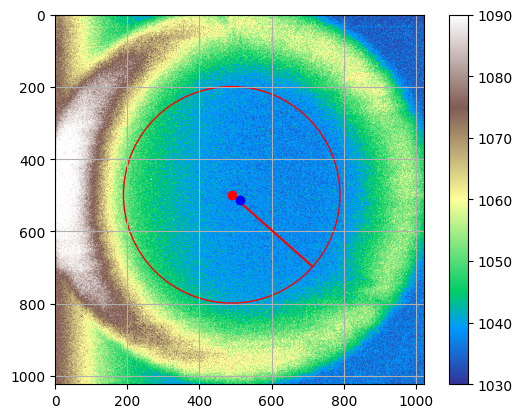

In [13]:
def plot_2d(data: npt.NDArray,
            circle: Optional[Circle] = None,
            angle_deg: Optional[float] = None,
            ax: Optional[plt.Axes] = None,
            a_min: Optional[float] = None,
            a_max: Optional[float] = None,
            cbar: bool = True,
            **kwargs):
    if ax is None:
        fig, ax = plt.subplots()
    current_a_min = a_min
    if a_min is None:
        current_a_min = np.nanpercentile(a=data, q=3)
    current_a_max = a_max
    if a_max is None:
        current_a_max = np.nanpercentile(a=data, q=97)
    im = ax.imshow(np.clip(data, a_min=current_a_min, a_max=current_a_max), cmap="terrain", **kwargs)
    if cbar:
        ax.figure.colorbar(im, ax=ax)
    if circle is not None:
        ax.add_artist(CirclePatch((circle.x, circle.y), circle.r, fill=False, color="red"))
        # add a point to the center of the circle
        ax.plot(circle.x, circle.y, "ro")
        if angle_deg is not None:
            angle_rad = np.deg2rad(angle_deg)
            radius_line = Line2D([circle.x, circle.x - circle.r * np.sin(angle_rad)],
                                 [circle.y, circle.y - circle.r * np.cos(angle_rad)],
                                 color="red")
            ax.add_artist(radius_line)
    ax.plot(data.shape[1] / 2, data.shape[0] / 2, "bo")
    ax.grid()
    return ax

ind = 3
plot_2d(df_signal_sobp.iloc[ind].raw_data, df_signal_sobp.iloc[ind].analysis_circle, df_signal_sobp.iloc[ind].det_angle);

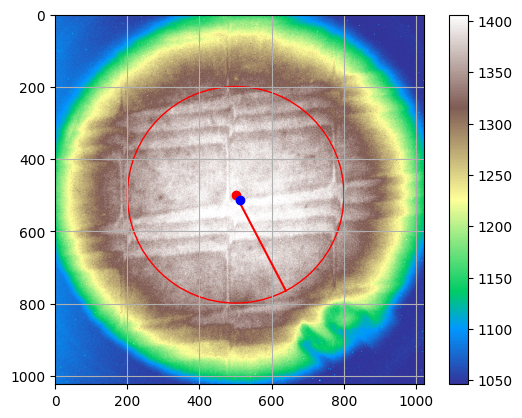

In [55]:
ind = 39
plot_2d(df_Co60.iloc[ind].raw_data, df_Co60.iloc[ind].analysis_circle, df_Co60.iloc[ind].det_angle);

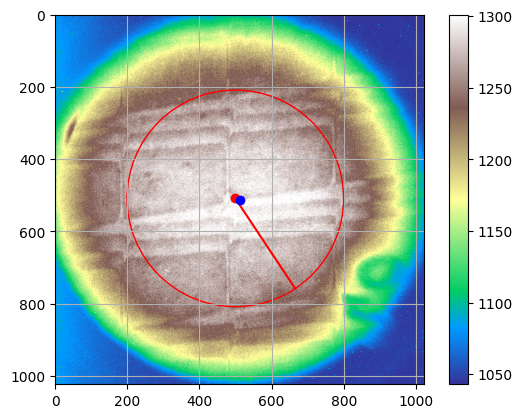

In [54]:
ind = 39
plot_2d(df_sobp.iloc[ind].raw_data, df_sobp.iloc[ind].analysis_circle, df_bp.iloc[ind].det_angle);

In [14]:
# fig, axes = plt.subplots(ncols=5, figsize=(20, 5))

# df_to_plot = df_ref

# ind = 0
# plot_2d(df_to_plot.iloc[ind].raw_data, df_to_plot.iloc[ind].analysis_circle, df_to_plot.iloc[ind].det_angle, ax=axes[0])
# axes[0].set_title(f"raw data μ={get_mean_std(df_to_plot.iloc[ind].raw_data, df_to_plot.iloc[ind].analysis_circle)[0]:.2f}")

# a_min = 0
# a_max = np.percentile(a=df_to_plot.iloc[ind].bg_sub, q=97)
# plot_2d(df_to_plot.iloc[ind].bg_sub, df_to_plot.iloc[ind].analysis_circle, df_to_plot.iloc[ind].det_angle, ax=axes[1], a_min=a_min, a_max=a_max)
# axes[1].set_title("bg sub μ={:.2f}".format(get_mean_std(df_to_plot.iloc[ind].bg_sub, df_to_plot.iloc[ind].analysis_circle)[0]))

# plot_2d(df_to_plot.iloc[ind].sensor_corr, df_to_plot.iloc[ind].analysis_circle, df_to_plot.iloc[ind].det_angle, ax=axes[2], a_min=a_min, a_max=a_max)
# axes[2].set_title("sensor corr μ={:.2f}".format(get_mean_std(df_to_plot.iloc[ind].sensor_corr, df_to_plot.iloc[ind].analysis_circle)[0]))

# plot_2d(df_to_plot.iloc[ind].centered, df_to_plot.iloc[ind].analysis_circle_centered, df_to_plot.iloc[ind].det_angle, ax=axes[3], a_min=a_min, a_max=a_max)
# axes[3].set_title("centered μ={:.2f}".format(get_mean_std(df_to_plot.iloc[ind].centered, df_to_plot.iloc[ind].analysis_circle_centered)[0]))

# plot_2d(df_to_plot.iloc[ind].rotated, df_to_plot.iloc[ind].analysis_circle_centered, 0, ax=axes[4], a_min=a_min, a_max=a_max)
# axes[4].set_title("rotated μ={:.2f}".format(get_mean_std(df_to_plot.iloc[ind].rotated, df_to_plot.iloc[ind].analysis_circle_centered)[0]));

# fig.tight_layout()

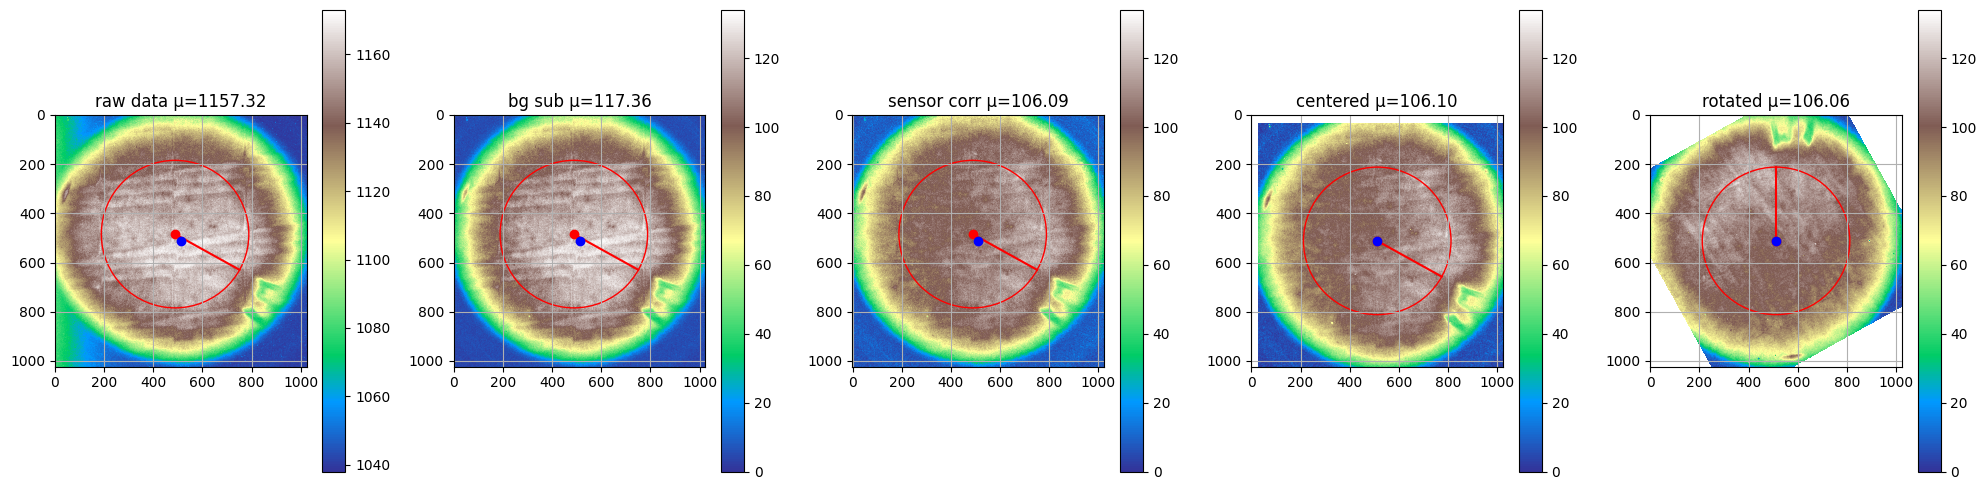

In [15]:
fig, axes = plt.subplots(ncols=5, figsize=(20, 5))

df_to_plot = df_signal_sobp

ind = 13
plot_2d(df_to_plot.iloc[ind].raw_data, df_to_plot.iloc[ind].analysis_circle, df_to_plot.iloc[ind].det_angle, ax=axes[0])
axes[0].set_title(f"raw data μ={get_mean_std(df_to_plot.iloc[ind].raw_data, df_to_plot.iloc[ind].analysis_circle)[0]:.2f}")

a_min = 0
a_max = np.percentile(a=df_to_plot.iloc[ind].bg_sub, q=97)
plot_2d(df_to_plot.iloc[ind].bg_sub, df_to_plot.iloc[ind].analysis_circle, df_to_plot.iloc[ind].det_angle, ax=axes[1], a_min=a_min, a_max=a_max)
axes[1].set_title("bg sub μ={:.2f}".format(get_mean_std(df_to_plot.iloc[ind].bg_sub, df_to_plot.iloc[ind].analysis_circle)[0]))

plot_2d(df_to_plot.iloc[ind].sensor_corr, df_to_plot.iloc[ind].analysis_circle, df_to_plot.iloc[ind].det_angle, ax=axes[2], a_min=a_min, a_max=a_max)
axes[2].set_title("sensor corr μ={:.2f}".format(get_mean_std(df_to_plot.iloc[ind].sensor_corr, df_to_plot.iloc[ind].analysis_circle)[0]))

plot_2d(df_to_plot.iloc[ind].centered, df_to_plot.iloc[ind].analysis_circle_centered, df_to_plot.iloc[ind].det_angle, ax=axes[3], a_min=a_min, a_max=a_max)
axes[3].set_title("centered μ={:.2f}".format(get_mean_std(df_to_plot.iloc[ind].centered, df_to_plot.iloc[ind].analysis_circle_centered)[0]))

plot_2d(df_to_plot.iloc[ind].rotated, df_to_plot.iloc[ind].analysis_circle_centered, 0, ax=axes[4], a_min=a_min, a_max=a_max)
axes[4].set_title("rotated μ={:.2f}".format(get_mean_std(df_to_plot.iloc[ind].rotated, df_to_plot.iloc[ind].analysis_circle_centered)[0]));

fig.tight_layout()

# Data inspection

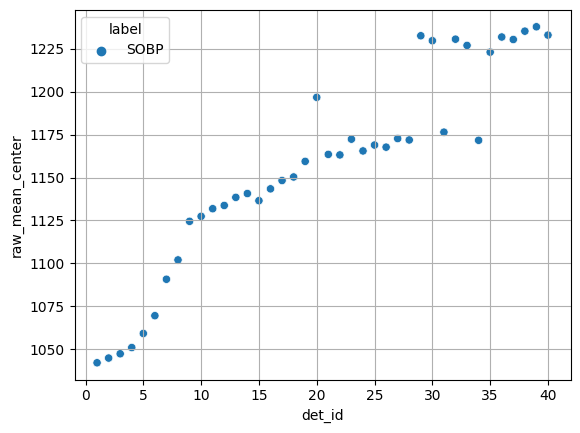

In [29]:
g = sns.scatterplot(data=df_signal_sobp, x="det_id", y="raw_mean_center", hue="label")
g.grid()

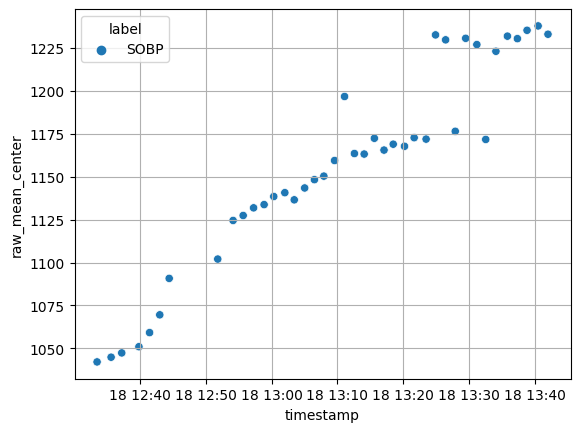

In [30]:
g = sns.scatterplot(data=df_signal_sobp, x="timestamp", y="raw_mean_center", hue="label")
g.grid()

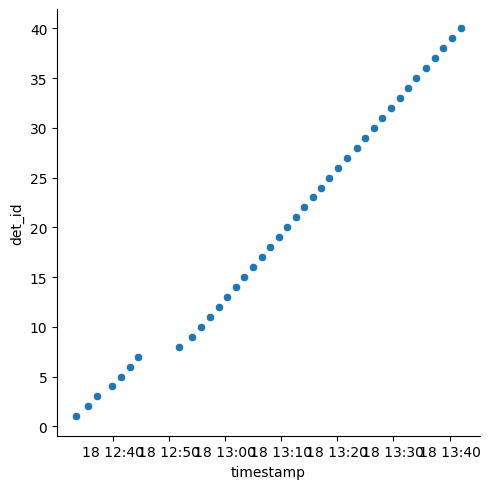

In [31]:
g = sns.relplot(data=df_signal_sobp, x="timestamp", y="det_id")

In [18]:
df_signal_sobp["dose_Gy"] = 60. * df_signal_sobp.rotated / df_signal_ref.rotated
df_signal_sobp["dose_Gy_mean"] = df_signal_sobp.apply(lambda tmpdf: get_mean_std(tmpdf.dose_Gy, tmpdf.analysis_circle_centered)[0], axis=1)
df_signal_sobp["dose_Gy_std"] = df_signal_sobp.apply(lambda tmpdf: get_mean_std(tmpdf.dose_Gy, tmpdf.analysis_circle_centered)[1], axis=1)

In [19]:
df_signal_bp["dose_Gy"] = 60. * df_signal_bp.rotated / df_signal_ref.rotated
df_signal_bp["dose_Gy_mean"] = df_signal_bp.apply(lambda tmpdf: get_mean_std(tmpdf.dose_Gy, tmpdf.analysis_circle_centered)[0], axis=1)
df_signal_bp["dose_Gy_std"] = df_signal_bp.apply(lambda tmpdf: get_mean_std(tmpdf.dose_Gy, tmpdf.analysis_circle_centered)[1], axis=1)

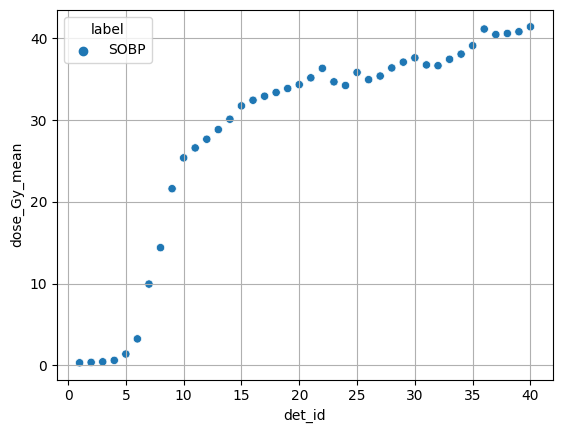

In [20]:
g = sns.scatterplot(data=df_signal_sobp, x="det_id", y="dose_Gy_mean", hue="label")
g.grid()

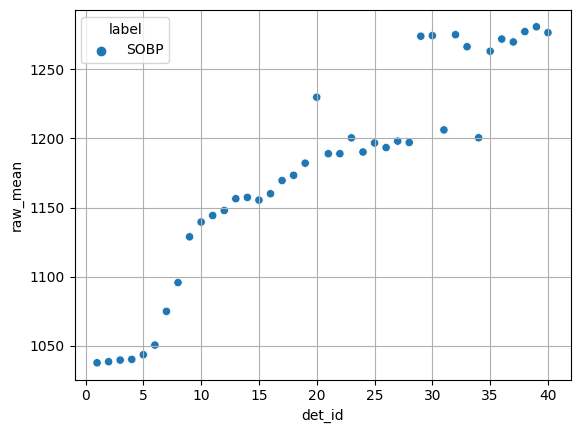

In [21]:
g = sns.scatterplot(data=df_signal_sobp, x="det_id", y="raw_mean", hue="label")
g.grid()

Text(0, 0.5, 'dose [Gy]')

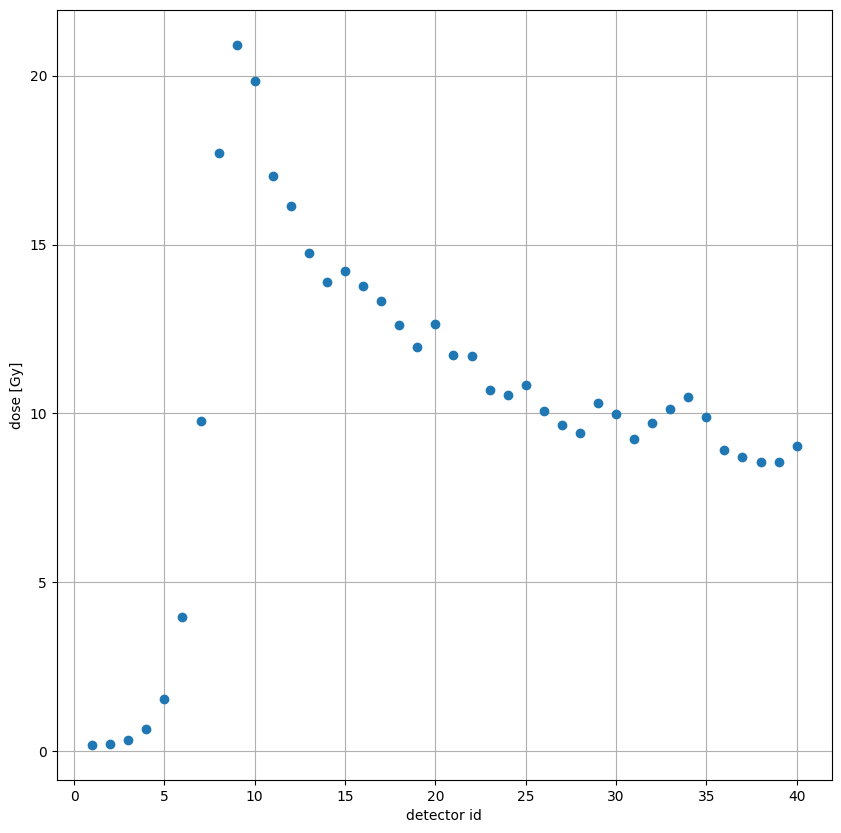

In [22]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(df_signal_bp.reset_index().det_id, df_signal_bp.dose_Gy_mean, label="BP", marker="o", linestyle="None")
ax.grid()
ax.set_xlabel("detector id")
ax.set_ylabel("dose [Gy]")

In [23]:
df_signal_bp.dose_Gy_mean.iloc[-4:] / 12

det_id
37    0.725669
38    0.714629
39    0.714336
40    0.751982
Name: dose_Gy_mean, dtype: float64

In [24]:
df_signal_sobp.dose_Gy_mean.iloc[-4:] / 60

det_id
37    0.674510
38    0.676765
39    0.680336
40    0.690393
Name: dose_Gy_mean, dtype: float64

Text(0, 0.5, 'dose [Gy]')

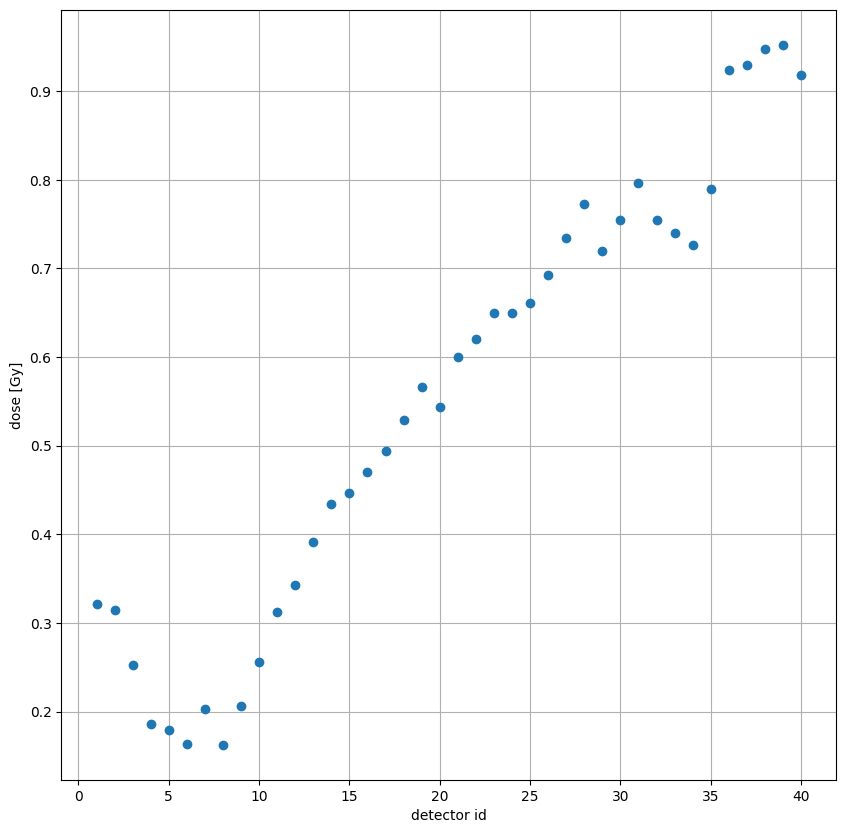

In [25]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(df_signal_bp.reset_index().det_id, (df_signal_sobp.dose_Gy_mean / 60) / (df_signal_bp.dose_Gy_mean / 12), label="efficiency", marker="o", linestyle="None")
ax.grid()
ax.set_xlabel("detector id")
ax.set_ylabel("dose [Gy]")

<AxesSubplot: >

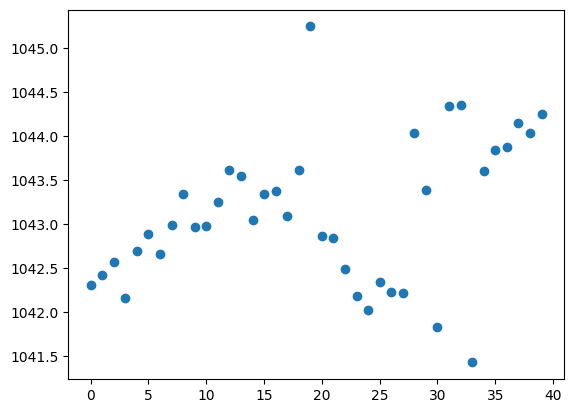

In [42]:
df_Co60.apply(lambda row : row.raw_data[-50:,-50:].mean(), axis=1).plot(style='o')

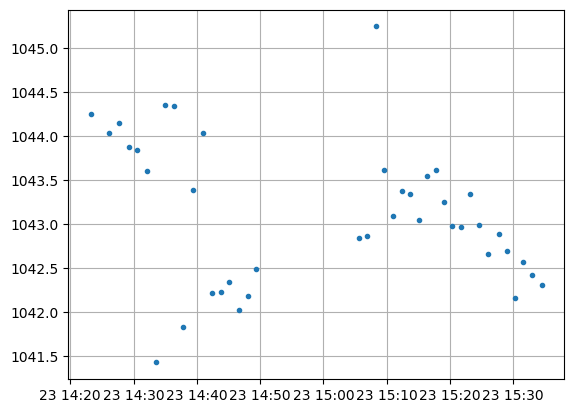

In [48]:
y = df_Co60.apply(lambda row : row.raw_data[-50:,-50:].mean(), axis=1)
x = df_Co60.timestamp.values
plt.plot(x, y, '.')
plt.grid()

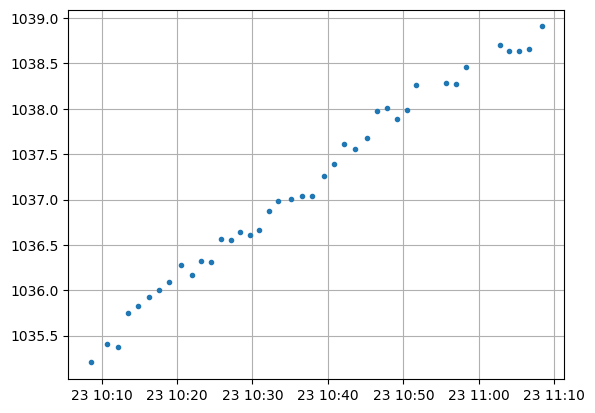

In [49]:
y = df_pre_bg.apply(lambda row : row.raw_data[-50:,-50:].mean(), axis=1)
x = df_pre_bg.timestamp.values
plt.plot(x, y, '.')
plt.grid()

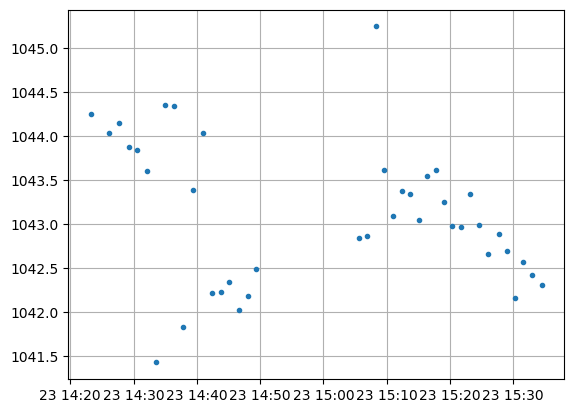

In [50]:
y = df_Co60.apply(lambda row : row.raw_data[-50:,-50:].mean(), axis=1)
x = df_Co60.timestamp.values
plt.plot(x, y, '.')
plt.grid()

<AxesSubplot: >

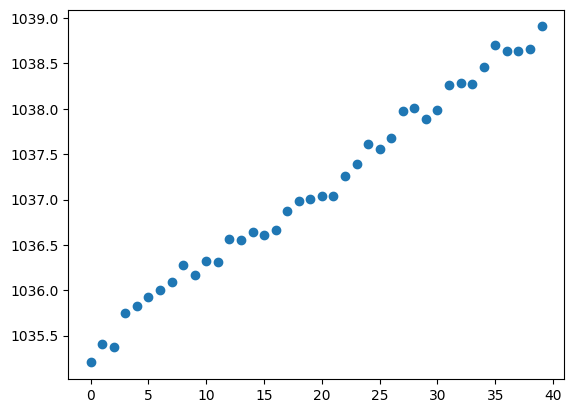

In [41]:
df_pre_bg.apply(lambda row : row.raw_data[-50:,-50:].mean(), axis=1).plot(style='o')

<AxesSubplot: >

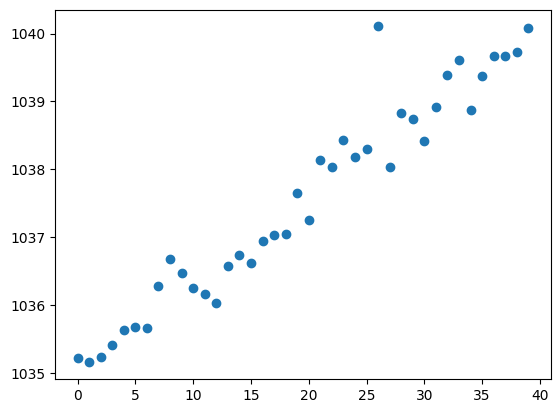

In [43]:
df_bp.apply(lambda row : row.raw_data[-50:,-50:].mean(), axis=1).plot(style='o')

<AxesSubplot: >

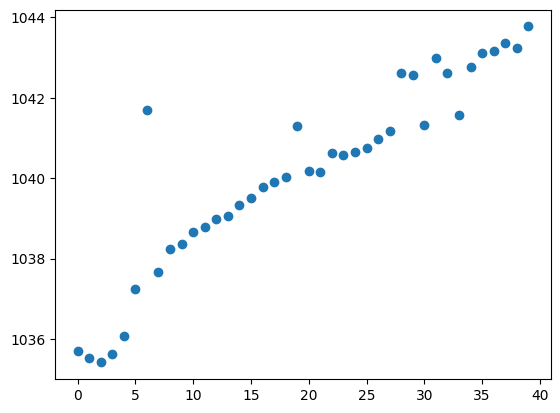

In [44]:
df_sobp.apply(lambda row : row.raw_data[-50:,-50:].mean(), axis=1).plot(style='o')